<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: Data Scientist в Segmento Екатерина Демидова

# <center>Домашнее задание 2. <br> Визуальный анализ данных о публикациях на Хабрахабре</center>

In [1]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

## Загрузка и знакомство с данными

Для работы вам понадобятся данные из нашего учебного конкурса на kaggle [«Прогноз популярности статьи на Хабре»](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm). Файл **`howpop_train.csv`** уже лежит в нашем репозитории в каталоге **`data`**, но его можно скачать и с Kaggle.

In [2]:
df = pd.read_csv('../../data/howpop_train.csv')

In [3]:
df.shape

(134137, 17)

In [4]:
df.head(3).T

,0,1,2
url,https://habrahabr.ru/post/18284/,https://habrahabr.ru/post/18285/,https://habrahabr.ru/post/18286/
domain,habrahabr.ru,habrahabr.ru,habrahabr.ru
post_id,18284,18285,18286
published,2008-01-01 18:19:00,2008-01-01 18:30:00,2008-01-01 18:34:00
author,@Tapac,@DezmASter,@DezmASter
flow,develop,design,design
polling,False,False,False
content_len,4305,7344,8431
title,Новогодний подарок блоггерам — WordPress 2.3.2,"Сумасшедшие яйца, или сервис для отслеживания ...","Сумасшедшие яйца, или сервис для отслеживания ..."
comments,0,1,47


Избавимся сразу от переменных, названия которых заканчиваются на `_lognorm` (нужны для соревнования на Kaggle). Выберем их с помощью `filter()` и удалим `drop`-ом:

In [5]:
df.drop(filter(lambda c: c.endswith('_lognorm'), df.columns), 
        axis = 1,       # axis = 1: столбцы 
        inplace = True) # избавляет от необходимости сохранять датасет

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
post_id,134137.0,181307.054265,81766.350702,18284.0,115565.0,182666.0,257401.0,314088.0
content_len,134137.0,7516.929699,8724.771640,1.0,2179.0,4949.0,9858.0,352471.0
comments,134137.0,39.625994,62.398958,0.0,7.0,19.0,48.0,2266.0
favs,134137.0,71.999866,145.854135,0.0,8.0,27.0,78.0,8718.0
views,134137.0,16631.013084,31479.819691,3.0,2100.0,7600.0,18700.0,1730000.0
votes_plus,133566.0,35.536888,42.461073,0.0,11.0,22.0,45.0,1466.0
votes_minus,133566.0,8.050035,11.398282,0.0,2.0,5.0,10.0,445.0


In [7]:
df.describe(include = ['object', 'bool'] # бинарные и категориальные переменные
           ).T

,count,unique,top,freq
url,134137,134137,https://habrahabr.ru/company/google/blog/47519/,1
domain,134137,2,habrahabr.ru,97048
published,134137,130291,2011-06-14 15:52:00,39
author,97657,22077,@alizar,5292
flow,97048,6,develop,53318
polling,134137,2,False,129412
title,134137,133628,"Интересные события, произошедшие в выходные",56


In [8]:
# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })

Столбец **`published`** (время публикации) содержит строки. Чтобы мы могли работать с этими данными как с датой/временем публикации, приведём их к типу `datetime`:

In [9]:
print(df.published.dtype)
df['published'] = pd.to_datetime(df.published, yearfirst = True)
print(df.published.dtype)

object
datetime64[ns]


Создадим несколько столбцов на основе данных о времени публикации:

In [10]:
df['year'] = [d.year for d in df.published]
df['month'] = [d.month for d in df.published]

df['dayofweek'] = [d.isoweekday() for d in df.published]
df['hour'] = [d.hour for d in df.published]

-----
Теперь Ваша очередь. В каждом пункте предлагается построить картинку и с ее помощью ответить на вопрос в [форме](https://docs.google.com/forms/d/e/1FAIpQLSf3b5OG8zX_nLQBQ-t20c6M5Auz-VUL-yxj8Fm9_o_XWDBTrg/viewform?c=0&w=1). Конечно, можно попытаться ответить на все вопросы только с Pandas, без картинок, но мы советуем Вам потренироваться строить (красивые) визуализации.   

## 1\. В каком месяце (и какого года) было больше всего публикаций?

* март 2016,
* март 2015,
* апрель 2015,
* апрель 2016.

year  month
2015  3        2189
      4        2110
2016  3        2115
      4        1910
Name: title, dtype: int64


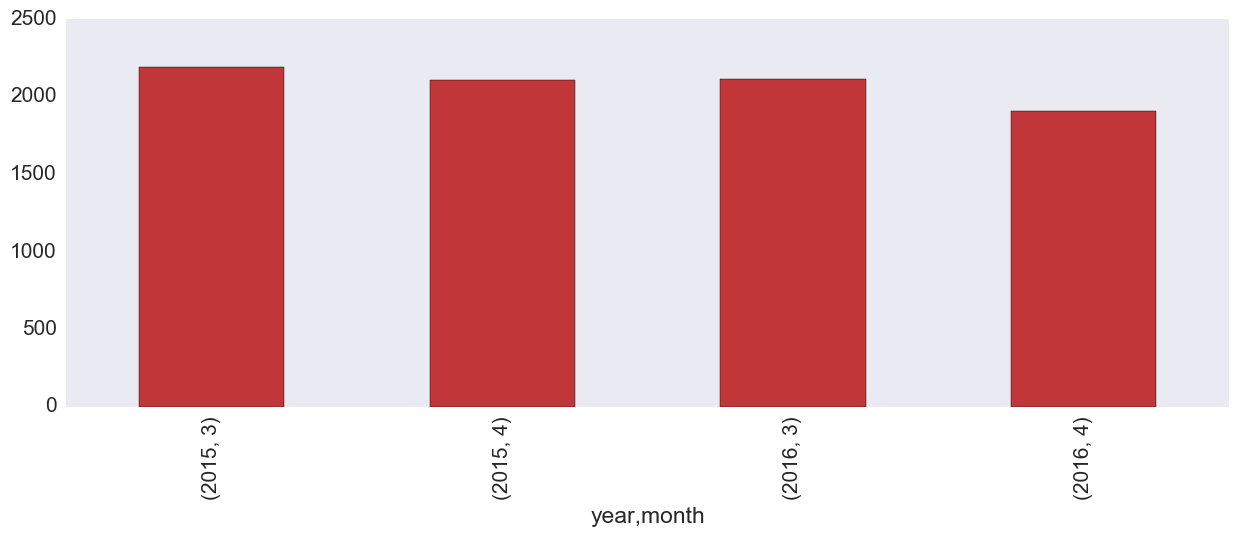

In [11]:
pubs_by_dates = df[df.apply(lambda x: (x['year'] in [2015, 2016]) & (x['month'] in [3, 4]), axis=1)]\
                    .groupby(['year', 'month'])['title'].count()
print(pubs_by_dates)
pubs_by_dates.plot(kind='bar')

## 2\. Проанализируйте публикации в этом месяце (из вопроса 1)

Выберите один или несколько вариантов:

* На графике не заметны какие-либо выбросы или аномалии,
* Один или несколько дней сильно выделяются из общей картины,
* На хабре _всегда_ больше статей, чем на гиктаймсе,
* По субботам на гиктаймс и на хабрахабр публикуют примерно одинаковое число статей.

Подсказки: постройте график зависимости числа публикаций от дня; используйте параметр `hue`

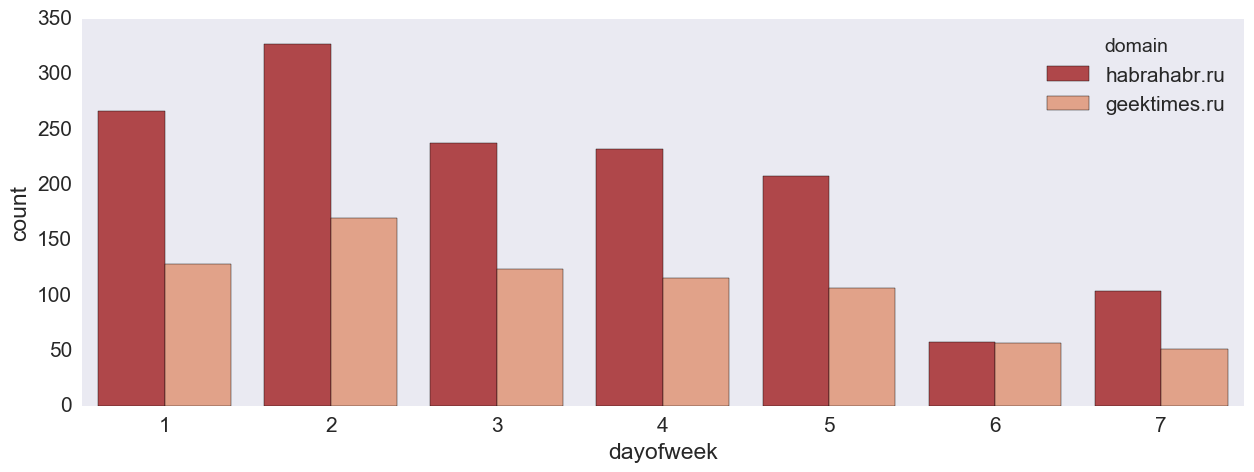

In [12]:
sns.countplot(x='dayofweek', hue='domain', data=df[(df['year'] == 2015) & (df['month'] == 3)])

In [13]:
habr_publications_by_days = df[(df['domain'] == 'habrahabr.ru') & (df['year'] == 2015) & (df['month'] == 3)]\
                            .groupby('dayofweek')['title'].count().to_frame()

trace0 = go.Bar(
    x=habr_publications_by_days.index,
    y=habr_publications_by_days['title'],
    name='Number of publications on habr'
)

geek_publications_by_days = df[(df['domain'] == 'geektimes.ru') & (df['year'] == 2015) & (df['month'] == 3)]\
                            .groupby('dayofweek')['title'].count().to_frame()

trace1 = go.Bar(
    x=geek_publications_by_days.index,
    y=geek_publications_by_days['title'],
    name='Number of publications on geek'
)

data = [trace0, trace1]
layout = {'title': 'Publications by days'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

## 3\. Выберите верное утверждение

* Больше всего просмотров (в среднем) набирают статьи, опубликованные в 12 часов дня;
* У опубликованных в 10 утра постов больше всего комментариев  (в среднем);
* Больше всего просмотров  (в среднем) набирают статьи, опубликованные в 6 часов утра;
* Максимальное число комментариев на гиктаймсе набрала статья, опубликованная в 9 часов вечера;
* На хабре дневные статьи комментируют чаще  (в среднем), чем вечерние.

In [14]:
views_by_hours_df = df.groupby('hour')['views'].mean().to_frame()

trace0 = go.Bar(
    x=views_by_hours_df.index,
    y=views_by_hours_df['views'],
    name='Mean views'
)

data = [trace0]
layout = {'title': 'Views by hours'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

In [15]:
geek_df = df[df['domain'] == 'geektimes.ru']

data = []

for hour in df['hour'].unique():
    data.append(
        go.Box(y=geek_df[geek_df['hour'] == hour]['comments'], name=hour)
    )
iplot(data, show_link = False)

In [16]:
comments_by_hours_df = df.groupby('hour')['comments'].mean().to_frame()

trace0 = go.Bar(
    x=comments_by_hours_df.index,
    y=comments_by_hours_df['comments'],
    name='Mean comments'
)

data = [trace0]
layout = {'title': 'Comments by hours'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

In [91]:
comments_by_hours_df = df[df['domain'] == 'habrahabr.ru'].groupby('hour')['comments'].mean().to_frame()

trace0 = go.Bar(
    x=comments_by_hours_df.index,
    y=comments_by_hours_df['comments'],
    name='Mean comments'
)

data = [trace0]
layout = {'title': 'Comments by hours on habrahabr.ru'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

## 4\. Кого из топ-20 авторов (по числу статей) чаще всего минусуют (в среднем)?

* @Mordatyj
* @Mithgol
* @alizar
* @ilya42

In [17]:
top_20_authors = df.groupby('author')['title'].count().sort_values(ascending=False)[0:19].index.values
authors_by_minuses = df[df.apply(lambda x: x['author'] in top_20_authors, axis=1)]\
                        .groupby('author')['votes_minus'].mean().to_frame()

trace0 = go.Bar(
    x=authors_by_minuses.index,
    y=authors_by_minuses['votes_minus'],
    name='Mean minus votes'
)

data = [trace0]
layout = {'title': 'Authors by minus votes'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

## 5\. Сравните субботы и понедельники

Правда ли, что по субботам авторы пишут в основном днём, а по понедельникам — в основном вечером?

In [18]:
saturday_publications_df = df[df['dayofweek'] == 6].groupby('hour')['title'].count().to_frame()
saturday_publications_df
trace0 = go.Bar(
    x=saturday_publications_df.index,
    y=saturday_publications_df['title'],
    name='Number of publications'
)

data = [trace0]
layout = {'title': 'Publications by hours at Saturday'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

In [19]:
monday_publications_df = df[df['dayofweek'] == 1].groupby('hour')['title'].count().to_frame()

trace0 = go.Bar(
    x=monday_publications_df.index,
    y=monday_publications_df['title'],
    name='Number of publications'
)

data = [trace0]
layout = {'title': 'Publications by hours at Monday'}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)